In [60]:
import numpy as np
from skimage import io
from skimage.restoration import estimate_sigma
from skimage.segmentation import slic, mark_boundaries
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
from pprint import pprint
import csv
import os

In [61]:
def estimate_noise(img):
    return estimate_sigma(img, multichannel=True, average_sigmas=True)

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


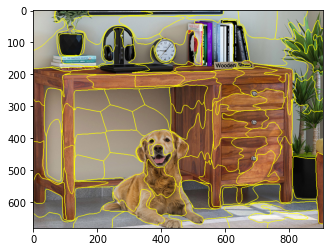

In [62]:
path = 'data/2-noise-estimation'
orig_filename = '1-1-original-background'
filename = '2-1-spliced-original'
ext = 'png'

img = io.imread(f'{path}/{filename}.{ext}')
img = img[:, :, :3]
img_shape = img.shape
orig = io.imread(f'{path}/{orig_filename}.{ext}')
orig = orig[:, :, :3]

segments = slic(img, n_segments=100, sigma=5, start_label=1)
plt.imshow(mark_boundaries(img, segments))
io.imsave(f'outs/segmented-{filename}.png', mark_boundaries(img, segments))
plt.show()

In [63]:
def shrink_image(img, range):
    img_shape = img.shape
    return img[
        range.get('min_row'):range.get('max_row') + 1,
        range.get('min_col'):range.get('max_col') + 1
    ]

In [64]:
labels = set()
for i in range(img_shape[0]):
    for j in range(img_shape[1]):
        if segments[i][j] not in labels:
            labels.add(segments[i][j])

superpixels = []
for i in range(len(labels)):
    superpixels.append(np.zeros(img_shape))

ranges = []
for i in range(len(labels)):
    ranges.append({
        'min_row': -1,
        'max_row': -1,
        'min_col': -1,
        'max_col': -1
    })

def max(a, b):
    return a if a > b else b
def min(a, b):
    return a if a < b else b

for i in range(img_shape[0]):
    for j in range(img_shape[1]):
        [r, g, b] = img[i][j]
        sum = int(r) + int(g) + int(b)
        label_index = segments[i][j] - 1
        superpixels[label_index][i][j] = img[i][j]
        if ranges[label_index].get('min_row') == -1:
            ranges[label_index]['min_row'] = i
        if ranges[label_index].get('min_col') == -1:
            ranges[label_index]['min_col'] = j
        ranges[label_index]['max_row'] = max(ranges[label_index].get('max_row'), i)
        ranges[label_index]['max_col'] = max(ranges[label_index].get('max_col'), j)

In [65]:
# for i in range(len(labels)):
#     io.imsave(f'outs/seg/seg-{i}.png', superpixels[i])

for i in range(len(labels)):
    superpixels[i] = shrink_image(superpixels[i], ranges[i])

noises = []
for i in range(len(labels)):
    noises.append(estimate_noise(superpixels[i]))

C:\ProgramData\Anaconda3\lib\site-packages\skimage\restoration\_denoise.py:911: UserWarning: image is size 4 on the last axis, but multichannel is False.  If this is a color image, please set multichannel to True for proper noise estimation.
  sigmas = [estimate_sigma(


In [66]:
with open(f'noises-{filename}.csv', 'w') as f:
    writer = csv.writer(f)
    writer.writerow(['Superpixel', 'Sigma'])
    writer.writerows(zip(range(len(noises)), noises))

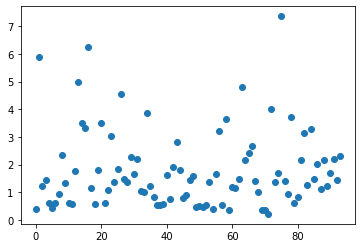

In [67]:
plt.scatter(range(len(noises)), noises)
plt.savefig(f'plot-{filename}.png', bbox_inches='tight', dpi=500)
plt.show()

In [68]:
data = np.array(noises)
kmeans = KMeans(n_clusters=2, init='k-means++').fit(data.reshape(-1,1))
out = kmeans.predict(data.reshape(-1,1))

# kmeans.cluster_centers_

Lossy conversion from float64 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


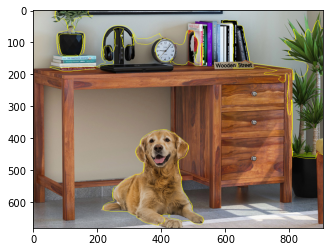

In [69]:
i_segmented = np.zeros((img_shape[0], img_shape[1]))

for i in range(img_shape[0]):
    for j in range(img_shape[1]):
        i_segmented[i][j] = out[segments[i][j] - 1]

i_segmented = np.array(i_segmented, dtype='int64')

marked = mark_boundaries(img, i_segmented)
plt.imshow(marked)
io.imsave(f'out-{filename}.png', marked)
plt.show()

In [70]:
def equals(a, b):
    for i in range(len(a)):
        if not a[i] == b[i]:
            return False
    return True

spliced_label = []
for i in range(img_shape[0]):
    spliced_label_row = []
    for j in range(img_shape[1]):
        spliced_label_row.append(0 if equals(img[i][j], orig[i][j]) else 1)
    spliced_label.append(spliced_label_row)
spliced_label = np.array(spliced_label, dtype='int64')




In [71]:
tp = 0
fp = 0
tn = 0
fn = 0

for i in range(img_shape[0]):
    for j in range(img_shape[1]):
        count += 1
        if i_segmented[i][j] == 1 and spliced_label[i][j] == 1:
            tp += 1
        elif i_segmented[i][j] == 1 and spliced_label[i][j] == 0:
            fp += 1
        elif i_segmented[i][j] == 0 and spliced_label[i][j] == 0:
            tn += 1
        elif i_segmented[i][j] == 0 and spliced_label[i][j] == 1:
            fn += 1

precision = tp / (tp + fp)
recall = tp / (tp + fn)
f_1 = tp / (tp + ((fp + fn) / 2))

pprint({
    'rows': img_shape[0],
    'cols': img_shape[1],
    'total': img_shape[0] * img_shape[1]
})
pprint({
    'True positives': tp,
    'False positives': fp,
    'True negatives': tn,
    'False negatives': fn
})
pprint({
    'precision': precision,
    'recall': recall,
    'F_1 score': f_1
})

{'cols': 906, 'rows': 680, 'total': 616080}
{'False negatives': 3300,
 'False positives': 69211,
 'True negatives': 496095,
 'True positives': 47474}
{'F_1 score': 0.5669925175714653,
 'precision': 0.4068560654754253,
 'recall': 0.9350061054870603}
